In [1]:
date = '2017-10-01'

In [2]:
%matplotlib inline

In [3]:
import json
import pandas as pd
import numpy as np

In [4]:
dfs = {}
for name in ['loginLog', 'Rating', 'RoadSegment', 'Users', 'Video', 'VideoRoadSeg']:
    dfs[name] = pd.read_csv('DB-backup/%s/%s.csv' %(date, name), index_col=0)

# remove test user

# Statistics of Users:

- completeness of survey
- number of users in each exp-lvl group

In [5]:
users = dfs['Users']
users.email.fillna('', inplace=True)
nontest_users = users[~users.email.str.contains('test')]
nontest_uid = nontest_users.user_id
print(users.shape, nontest_users.shape)
users = nontest_users

(162, 16) (159, 16)


{1.0: 149, 0.0: 10}


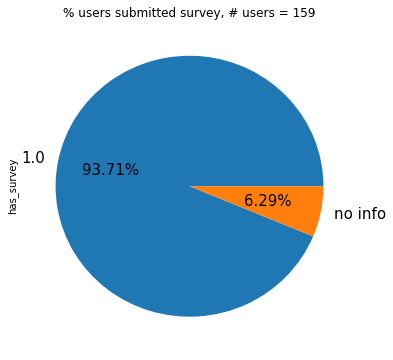

In [43]:
print(users.has_survey.fillna(0).value_counts().to_dict())
users.has_survey.fillna('no info').value_counts().plot(kind='pie',autopct='%.2f%%', figsize=(6,6), fontsize=15, title='%% users submitted survey, # users = %d' % users.shape[0])

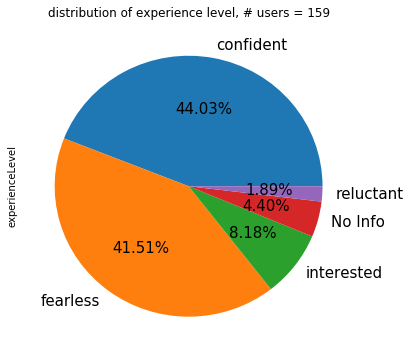

In [44]:
users.experienceLevel.fillna('No Info').value_counts().plot(kind='pie',autopct='%.2f%%', figsize=(6,6), fontsize=15,
                                                        title = 'distribution of experience level, # users = %d' % users.shape[0])

In [49]:
users.ix[users.age==63, 'age'] = pd.np.nan

D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [86]:
survey_dict = {
    'bk_purpose': ['No Info', 'Mainly utility biking – traveling from one location to another', 'Mainly recreational biking – biking for recreation, leisure, and health', '50% utility, 50% recreational'],
    'age': ['No Info', '< 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '>=75',],
    'ethnicity': ['No Info', 'White', 'Hispanic or Latino', 'Black or African American', 'Native American or American Indian', 'Asian / Pacific Islander', 'Other',],
    'edu': ['No Info', 'Nursery school to some high school, no diploma', 'High school graduate, diploma or the equivalent (for example: GED)', 'Some college credit, no degree', 'Associate degree', 'Bachelor’s degree', 'Master’s degree', 'Doctorate degree'],
    'marital': ['No Info', 'Single, never married', 'Married or domestic partnership', 'Widowed', 'Divorced', 'Separated'],
    'gender': ['No Info', 'Female', 'Male', 'Transgender – Female', 'Transgender – Male', 'Gender-variant / Non-conforming', 'Not listed', ],
    'driver': ['no', 'yes','No Info'],
    'car': ['no', 'yes','No Info'],
    'household_income': ['No Info', 'Less than \$24,999', '\$25,000 to \$39,999', '\$40,000 to \$54,999', '\$55,000 to \$69,999', '\$70,000 to \$84,999', '\$85,000 to \$99,999', '\$100,000 to \$149,999', '\$150,000 or more'],
    'residence': ['No Info', 'Never', '<3 months', '3-6 months', '6-12 months', '1-3 years', '>=3 years'],
    'bk_type': ['No Info', 'CaBi Bike (Shared bike in the DC region)', 'Road Bike', 'Mountain Bike', 'Hybrid Bike', 'Cruiser Bike', 'BMX Bike', 'Folding Bike', 'Recumbent Bike', 'Tandem Bike', 'Do not ride a bike', 'other bk type'],
}

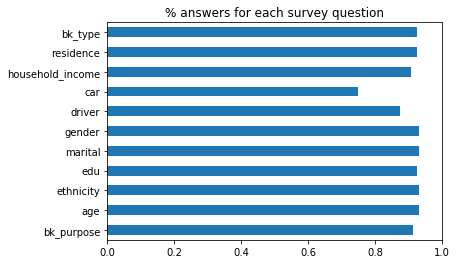

In [72]:
survey_cols = ['bk_purpose', 'age', 'ethnicity', 'edu', 'marital', 'gender', 'driver','car', 'household_income', 'residence', 'bk_type']
(~users[survey_cols].isnull()).mean().plot(kind='barh', xlim =(0,1), title='% answers for each survey question')

In [73]:
num_users = users.shape[0]

percent: False col: bk_purpose


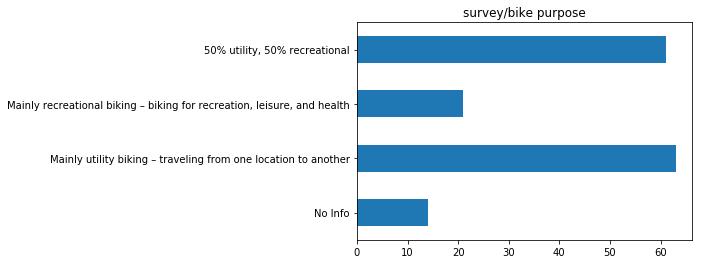

In [95]:
plot_pcnt = True
plot_pcnt = False
col = survey_cols[0]
# col = survey_cols[1]
# col = survey_cols[2]
# col = survey_cols[3]
# col = survey_cols[4]
# col = survey_cols[5]
# col = survey_cols[6]
# col = survey_cols[7]
# col = survey_cols[8]
# col = survey_cols[9]
# col = survey_cols[10]
df_temp = users[col].fillna('No Info').apply(lambda x: survey_dict[col][int(x)] if not x=='No Info' else x).value_counts().to_frame()
if plot_pcnt: df_temp = df_temp/num_users
df_temp =df_temp.reindex(survey_dict[col])
ax = df_temp.plot(kind='barh', legend=False, title='survey/%s' % col\
      .replace('_', ' ')\
      .replace('bk', 'bike')\
      .replace('edu', 'education')\
      .replace('driver', 'have driver license')\
      .replace('car', 'have access to a car')\
      .replace('residence', 'Time of Residence in DC'))


vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) if plot_pcnt else int(x) for x in vals])
print('percent:', plot_pcnt, 'col:', col)

# Statistics of loginLog

- distribution of # logins per user
- mobile vs PC
- distribution over time

In [96]:
logs = dfs['loginLog']
logs = logs.merge(users[['user_id', 'email']])

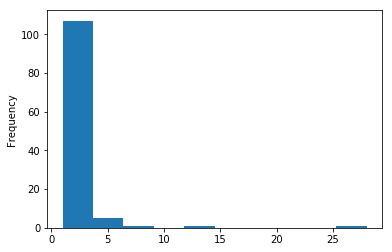

In [97]:
logs.groupby('user_id').count().lid.plot(kind='hist')

not Mobile    198
mobile         45
Name: isMobile, dtype: int64

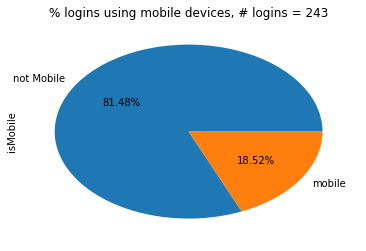

In [98]:
logs.isMobile.apply(lambda x: 'not Mobile' if pd.isnull(x) else 'mobile').value_counts().plot('pie',
                                                                                       autopct='%.2f%%', 
                                                                                       title='%% logins using mobile devices, # logins = %d' % logs.shape[0])
logs.isMobile.apply(lambda x: 'not Mobile' if pd.isnull(x) else 'mobile').value_counts()

In [99]:
logs.timezone = logs.timezone.fillna('')
logs.timezone = logs.timezone.apply(lambda x: x.replace('GMT', '').strip()).apply(lambda x: 0 if x=='' else int(x))
logs['offset'] = logs.timezone.apply(lambda x: abs(x))
logs['direction'] = logs.timezone.apply(lambda x: 1 if x>0 else -1)
logs['time'] = pd.to_datetime(logs.UTCts)
logs['time'] = logs.apply(lambda x: x.time + x.direction * pd.to_timedelta(x.offset, unit='h'), axis=1)

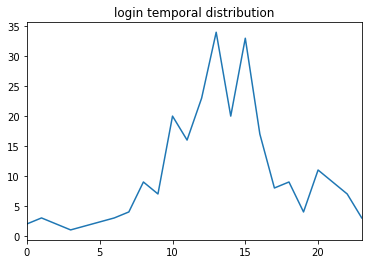

In [100]:
logs.time.apply(lambda x: x.hour).value_counts().sort_index().plot(title='login temporal distribution')

# Statistics of Ratings

- distribution of # ratings per user
- distribution of # ratings per login
- distribution of scores: overall; groupby user exp-lvl
- distribution of tags: overall; groupby score; groupby user exp-lvl
- agg comments
- normal rating(no skipping)
- aggregate comments and scores on a video/segment basis

In [6]:
ratings = dfs['Rating'].drop('email', axis=1)
videos=dfs['Video']
videos.shape,ratings.vid.nunique()

((549, 4), 510)

In [7]:
ratings = ratings.merge(users[['user_id','email', 'experienceLevel']], left_on='uid', right_on='user_id').drop('uid', axis=1).merge(videos[['vid','URL']])
ratings.experienceLevel = ratings.experienceLevel.fillna('No Info')
ratings.URL = ratings.URL.apply(lambda x: 'https://www.youtube.com/watch?v='+x)

In [8]:
num_ratings = ratings.shape[0]
num_ratings

1476

## familiarity distribution

no         721
yes        651
No Info    104
Name: familiar, dtype: int64


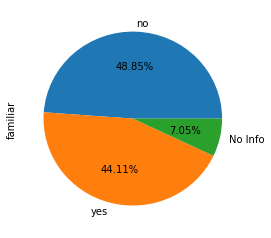

In [10]:
ratings.familiar = ratings.familiar.fillna('No Info')
print(ratings.familiar.value_counts())
ratings.familiar.fillna('No Info').value_counts().plot(kind='pie',autopct='%.2f%%', figsize=(4,4))

## distribution of number of ratings per user

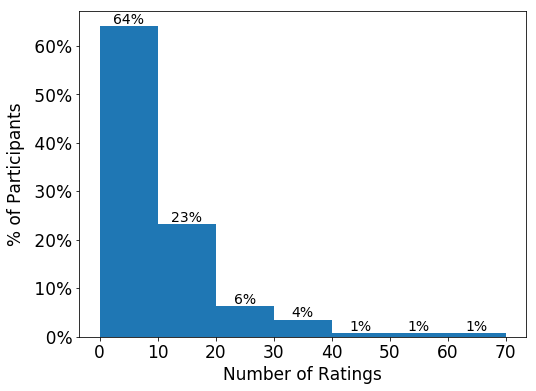

In [23]:

num_users = users.shape[0]
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
series = ratings.groupby('user_id').count().email
if plot_pcnt:
    ax = series.plot(kind='hist', figsize=(8,6),  bins=range(0, 80, 10), 
                 weights=np.ones_like(series) / len(series), fontsize=17)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
else:
    ax = series.plot(kind='hist', figsize=(8,6), rwidth=0.8, bins=range(0, 80, 10))

for p in ax.patches:
    if p.get_height()!=0:
#         height = '%.0f%% (%d)' % (p.get_height()*100, p.get_height()*num_users) if plot_pcnt else str(int(p.get_height()))
        height = '%.0f%%' % (p.get_height()*100) if plot_pcnt else str(int(p.get_height()))

        ax.annotate(height, (p.get_x() + p.get_width()/2 , p.get_height() + (0.005 if plot_pcnt else 1)), ha='center', fontsize=14) 
        

ax.set_xlabel('Number of Ratings', fontsize=17)
ax.set_ylabel(('# Participants' if not plot_pcnt else '% of Participants'), fontsize=17)


fig = ax.get_figure()
fig.savefig(u'plots/distribution of number of ratings per user%s.eps' % fn_suffix, format='eps', bbox_inches='tight', pad_inches=0.05)
fig.savefig(u'plots/distribution of number of ratings per user%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0.05)

## distribution of number of ratings per score

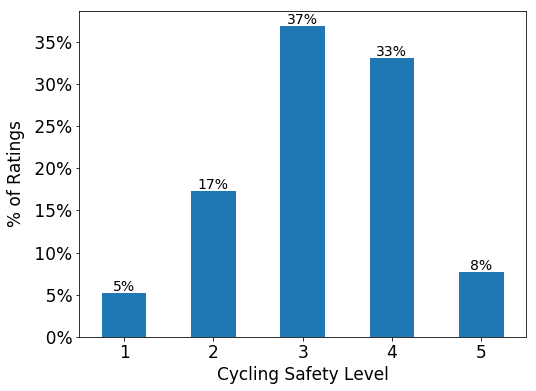

In [13]:
# title='distribution of number of ratings per score',
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
df_to_plot = ratings.score.value_counts().to_frame().sort_index()
if plot_pcnt: df_to_plot = df_to_plot/num_ratings
ax = df_to_plot.plot(kind='bar', figsize=(8,6),legend=False, fontsize=17)

if plot_pcnt: 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    
for p in ax.patches:
    if p.get_height()!=0:
#         height = '%.0f%% (%d)' % (p.get_height()*100, p.get_height()*num_ratings) if plot_pcnt else str(int(p.get_height()))
        height = '%.0f%%' % (p.get_height()*100) if plot_pcnt else str(int(p.get_height()))
        ax.annotate(height, (p.get_x() + p.get_width()/2 , p.get_height() + (0.003 if plot_pcnt else 1)), ha='center', fontsize=14) 
        
ax.set_xticklabels(df_to_plot.index, rotation=0)

ax.set_xlabel('Cycling Safety Level', fontsize=17)
# ax.set_ylabel(('# ratings' if not plot_pcnt else '% ratings')+' total=%d' % num_ratings, fontsize=17)
ax.set_ylabel(('# Ratings' if not plot_pcnt else '% of Ratings'), fontsize=17)

fig = ax.get_figure()
fig.savefig(u'plots/distribution of number of ratings per score%s.eps' % fn_suffix, format='eps', bbox_inches='tight', pad_inches=0.05)
fig.savefig(u'plots/distribution of number of ratings per score%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0.05)

### by familiarity

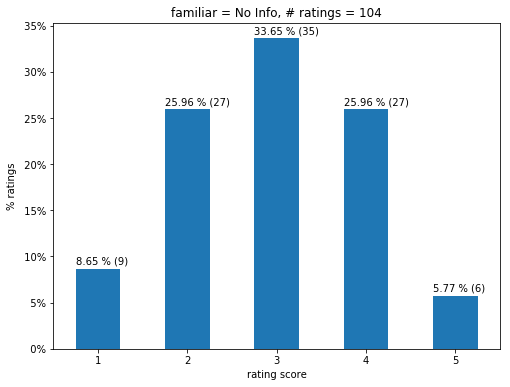

In [27]:
# title='distribution of number of ratings per score',
chosen_familiar = ['yes', 'no', 'No Info'][2]
sliced_ratings = ratings[ratings.familiar==chosen_familiar]
num_sliced_ratings = sliced_ratings.shape[0]
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
df_to_plot = sliced_ratings.score.value_counts().to_frame().sort_index()
if plot_pcnt: df_to_plot = df_to_plot/num_sliced_ratings
ax = df_to_plot.plot(kind='bar', figsize=(8,6),legend=False, title='familiar = %s, # ratings = %d' % (chosen_familiar, num_sliced_ratings))

if plot_pcnt: 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    
ax.set_xticklabels(df_to_plot.index, rotation=0)

ax.set_xlabel('rating score')
ax.set_ylabel('# ratings' if not plot_pcnt else '% ratings')

for p in ax.patches:
    height = '%.2f %% (%d)' % (p.get_height()*100, p.get_height()*num_sliced_ratings) if plot_pcnt else str(int(p.get_height()))
    
    ax.annotate(height, (p.get_x() , p.get_height() + (0.005 if plot_pcnt else 1)))

fig = ax.get_figure()
# fig.savefig(u'plots/distribution of number of ratings per score by familiar%s.eps' % fn_suffix, format='eps', bbox_inches='tight', pad_inches=0)
# fig.savefig(u'plots/distribution of number of ratings per score by familiar%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0)

### by experience level

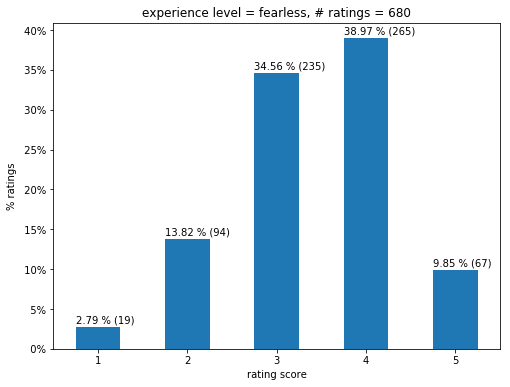

In [51]:
# title='distribution of number of ratings per score',
chosen_exp = ['fearless', 'confident', 'interested', 'reluctant', 'No Info'][0]
sliced_ratings = ratings[ratings.experienceLevel==chosen_exp]
num_sliced_ratings = sliced_ratings.shape[0]
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
df_to_plot = sliced_ratings.score.value_counts().to_frame().sort_index()
if plot_pcnt: df_to_plot = df_to_plot/num_sliced_ratings
ax = df_to_plot.plot(kind='bar', figsize=(8,6),legend=False, title='experience level = %s, # ratings = %d' % (chosen_exp, num_sliced_ratings))

if plot_pcnt: 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    
ax.set_xticklabels(df_to_plot.index, rotation=0)

ax.set_xlabel('rating score')
ax.set_ylabel('# ratings' if not plot_pcnt else '% ratings')

for p in ax.patches:
    height = '%.2f %% (%d)' % (p.get_height()*100, p.get_height()*num_sliced_ratings) if plot_pcnt else str(int(p.get_height()))
    
    ax.annotate(height, (p.get_x() , p.get_height() + (0.005 if plot_pcnt else 1)))

fig = ax.get_figure()
# fig.savefig(u'plots/distribution of number of ratings per score by exp%s.eps' % fn_suffix, format='eps', bbox_inches='tight', pad_inches=0)
# fig.savefig(u'plots/distribution of number of ratings per score by exp%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0)

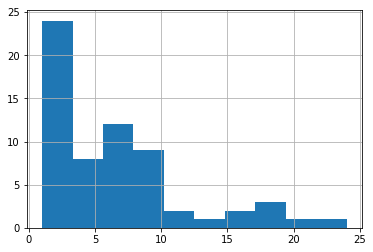

In [14]:
ratings.groupby('lid').count().email.hist()

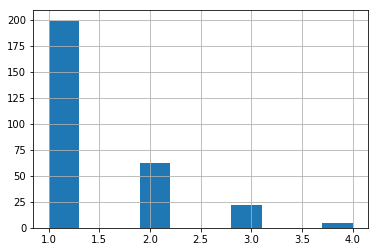

In [68]:
ratings.groupby('vid').count().email.hist()

In [93]:
ratings_w_comment = ratings[ratings.comment!='']
ratings_w_comment[['vid','comment','URL','score']].sort_values('vid')

,vid,comment,URL,score
99,102,"cobbles, narrow road, and rail tracks",https://www.youtube.com/watch?v=0SP5QFb3E98,2
50,108,"there are bike lanes on this road, more danger...",https://www.youtube.com/watch?v=Shz6cazUaa8,2
396,11,Q11 (what type of bike do you normally ride)\r...,https://www.youtube.com/watch?v=Hc_wZfeazVU,3
203,115,What's dangerous is going from bike lane to no...,https://www.youtube.com/watch?v=m9qvDsQrNXI,3
37,120,I would not transition to the sidewalk. That i...,https://www.youtube.com/watch?v=RSxhtMim6nA,4
77,123,bikes are better on roads than sidewalks... if...,https://www.youtube.com/watch?v=S-A71a0YRmE,2
75,123,I wouldn't ride on the sidewalk. Too narrow.,https://www.youtube.com/watch?v=S-A71a0YRmE,3
52,124,Rating not applicable — cyclist is riding on t...,https://www.youtube.com/watch?v=Suti47cmzew,3
53,124,riding on the sidewalk and jumping a red light,https://www.youtube.com/watch?v=Suti47cmzew,1
247,143,I don't quite understand the idea of rating a ...,https://www.youtube.com/watch?v=kpqZ0Cio_tA,4


In [15]:

def clean_tag(x):
    # over-length
    if x=='d':
        return 'driving quality'
    if x.startswith('door'):
        return 'dooring (car door might hit cyclist)'
    if x.startswith('nei'):
        return 'neighborhood security'
    if x.startswith('ped'):
        return 'pedestrians crossing'
    if x.startswith('road quality'):
        return 'road quality (paving)'
    if x.startswith('bike lane blocked (c'):
        return 'bike lane blocked (construction)'
    elif x.startswith('bike lane bl'):
        return 'bike lane blocked (vehicle)'
    
    # old tags
    if x=='lane_1' or x=='bike-lane' or x=='lane_0':
        return 'bike lane design (or lack of)'
    if x =='traf_1' or x=='among-cars':
        return 'traffic'
    if x=='weather_1':
        return 'weather'
    if x=='nbrh_1':
        return 'neighborhood security'
    if x =='construction':
        return 'bike lane blocked (construction)'
    if x=='cross-intersection':
        return 'intersection design'
    return x

temp = pd.Series([y for x in ratings.tags.fillna('').apply(lambda x: x.split(',')).values.tolist() for y in x])


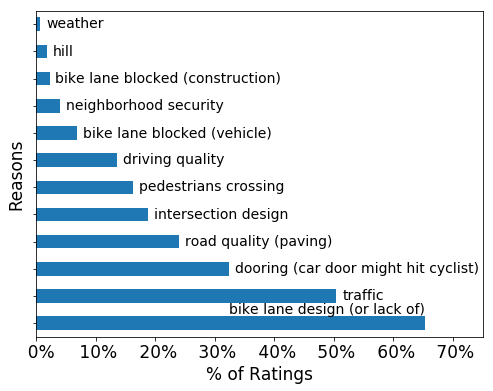

In [20]:
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
series_to_plot = temp[temp!=''].apply(clean_tag).value_counts()
factors = series_to_plot.index.tolist()
series_to_plot.index = [''  for i in range(series_to_plot.shape[0])]
if plot_pcnt: series_to_plot = series_to_plot/num_ratings
ax = series_to_plot.plot(kind='barh', figsize=(8,6), fontsize=17)
if plot_pcnt:
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    
ax.set_xlabel('Number of Ratings' if not plot_pcnt else '% of Ratings', fontsize=17)
ax.set_ylabel('Reasons', fontsize=17)
ax.set_xlim(right= 0.75 if  plot_pcnt else 1100)
max_x = series_to_plot.max()
offset = 10 if not plot_pcnt else 0.01
for i, r in enumerate(ax.patches):
    if i==0:
        ax.text(r.get_width() , r.get_y() + r.get_height()*1.2,factors[i], fontsize=14, ha='right')
    else:
        ax.text(r.get_width()+offset , r.get_y() + r.get_height()/5.,factors[i], fontsize=14,
#            bbox={"facecolor":"white",
#                       "alpha":0.2,
#                       "pad":1}
           )
    
fig = ax.get_figure()
fig.savefig(u'plots/distribution of factors affecting ratings%s.eps' % fn_suffix, format='eps', bbox_inches='tight', pad_inches=0.05)
fig.savefig(u'plots/distribution of factors affecting ratings%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0.05)

# Statistics of Segments

- distribution of number of ratings per segment
- distribution of std of score per segment

In [116]:
vid2seg = dfs['VideoRoadSeg']
segs = dfs['RoadSegment']

In [117]:
segs[segs['sumCnt']!=0].shape

(413, 7)

In [118]:
seg_type = pd.read_csv('seg_street_type.csv')
seg_type.columns = ['index_seg', 'street_type']
seg_type.index_seg.dtype

dtype('int64')

In [119]:
joint_table = ratings.merge(vid2seg[['vid', 'index_seg', 'ratio']].merge(segs[['index_seg', 'geometry']]))
joint_table[['index_seg', 'rid']].index_seg.nunique()

442

## ratings distribution over segment

In [120]:
joint_table.ratio = joint_table.ratio.astype(float) 
joint_table.score = joint_table.score.astype(float)
seg_ratings = joint_table.groupby('index_seg').apply(lambda x: (x.score* x.ratio).sum()/x.ratio.sum())

In [124]:
seg_ratings.shape

(442,)

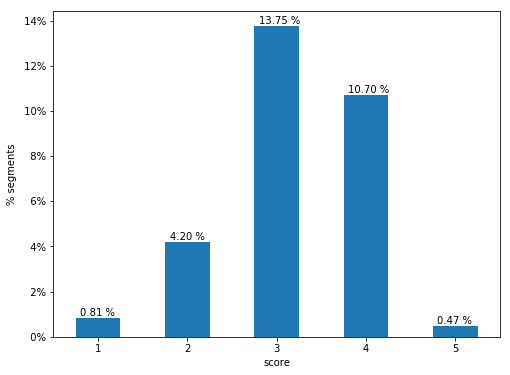

In [125]:
plot_pcnt = True
fn_suffix = ' (percentage)' if plot_pcnt else ''
df_to_plot = seg_ratings.round().astype(int).value_counts().to_frame().sort_index()
if plot_pcnt: df_to_plot = df_to_plot/num_ratings
ax = df_to_plot.plot(kind='bar', figsize=(8,6),legend=False,)

if plot_pcnt: 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

    
ax.set_xticklabels(df_to_plot.index, rotation=0)

ax.set_xlabel('score')
ax.set_ylabel('# segments' if not plot_pcnt else '% segments')

for p in ax.patches:
    height = '%.2f %%' % (p.get_height()*100) if plot_pcnt else str(int(p.get_height()))
    ax.annotate(height, (p.get_x()+(0.05 if plot_pcnt else 0.15) , p.get_height() + (0.001 if plot_pcnt else 1)))

fig = ax.get_figure()
fig.savefig(u'plots/distribution of number of segments per score%s.png' % fn_suffix, format='png', bbox_inches='tight', pad_inches=0)

## type coverage

In [126]:
df = joint_table[['index_seg', 'rid']].astype(int).merge(seg_type)

In [127]:
ratings_per_type = df.street_type.value_counts().to_frame()

In [128]:
cover_type = df.drop_duplicates('index_seg').street_type.value_counts().to_frame()
all_type = seg_type.street_type.value_counts().to_frame()
coverage = all_type.merge(cover_type, left_index=True, right_index=True, how='outer')
coverage['Coverage'] = coverage.iloc[:,1]/coverage.iloc[:, 0]
coverage.Coverage = coverage.Coverage.apply(lambda x: '%.2f%%' % (x*100) if not pd.isnull(x) else '-')
coverage = coverage.merge(ratings_per_type, left_index=True, right_index=True, how='outer')


In [129]:
coverage.columns = ['Number Segments in DC', 'Number Segments with ratings', 'Segments Coverage', 'Number Ratings']

In [130]:
dict_abbr = {
    'ST': 'Street', 'AVE': 'Avenue', 'PL': 'Place', 'RD': 'Road',
    'DR': ' Drive', 'CIR': 'Circle', 'TER': 'Terrace', 'LN': 'Lane',
    'CT': 'Crest', 'BLVD': 'Boulevard', 'OTHER': 'Unlabeled',
    'PKWY': 'Parkway', 'WAY': 'Way', 'CRES': 'Crescent',
}
coverage.index = coverage.index.map(lambda x: dict_abbr[x])

In [132]:
coverage.index.name='Segment Type'
coverage.fillna('-').to_csv('plots/segment_coverage.csv')

In [133]:
'# segments', seg_type.shape[0], 'covered', df.index_seg.nunique(), df.index_seg.nunique()/seg_type.shape[0]*100, '%'

('# segments', 13522, 'covered', 442, 3.2687472267416062, '%')